In [231]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import os.path as op
import numpy as np
import nibabel as nib

from pyhrf.boldsynth.hrf import getCanoHRF
from pyhrf.ndarray import xndarray
from pyhrf.plot import autocrop

archives = op.join('/media', 'aina', 'MISTIS', 'Data', 'BOLD data', 'Data_GIN_Em')
vem_dir = 'vem_mmvsms_8conds_9sess_lr_hyp_vh0.001_gh100000'
fig_dir = vem_dir + '_figs'
if not op.exists(fig_dir): os.makedirs(fig_dir)

subjects = ['283', '271', '291', '292', '274', '284', '288', '289', '273']
brf_n = 'jde_vem_asl_brf.nii'
brls_n = 'jde_vem_asl_brls.nii'
labels_n = 'jde_vem_asl_labels.nii'

In [232]:
# Parameters
tr = 2.
dt = tr / 2.
dur = 18.
n_scans = 126
taxis = np.arange(0., dur + dt, dt)
_, brf = getCanoHRF(dur, dt)
roi_hrf_list = np.array([1, 2])

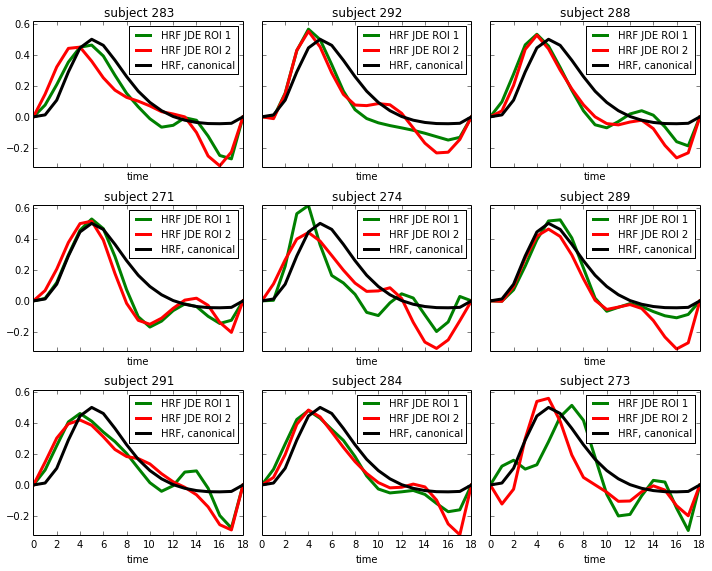

In [427]:
color = ['g', 'r']
f, ax = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True)
#f.suptitle('Estimated HRFs from V1 left and right', fontsize=14, fontweight='bold')
for isub, subject in enumerate(subjects[:]):
    brf_fn = op.join(archives, 'MAP-VS-' + subject, vem_dir, brf_n)
    brf_v0 = xndarray.load(brf_fn)
    for roi_hrf in roi_hrf_list:
        brf_v = brf_v0.sub_cuboid(ROI=roi_hrf)
        ax[isub%3, isub/3].plot(brf_v.axes_domains['time'], brf_v.data, color[roi_hrf - 1], linewidth=3,
                                label='HRF JDE ROI '+str(roi_hrf))
    ax[isub%3, isub/3].plot(brf_v.axes_domains['time'], brf, 'k', linewidth=3, label='HRF, canonical')
    ax[isub%3, isub/3].axis('tight')
    ax[isub%3, isub/3].set_xlabel('time')
    ax[isub%3, isub/3].set_title('subject ' + subject)
    ax[isub%3, isub/3].legend(prop={'size':10})
    fig_fn = op.join(fig_dir, 'vem_brf_%s_roi%d.png' % (subject, roi_hrf))
f.tight_layout()
f.savefig(fig_fn)
autocrop(fig_fn)


In [335]:
from pyhrf.paradigm import Paradigm

paradigm_l_fn = op.join(archives, 'paradigm_data', 'visual_block1b.csv')
paradigm_r_fn = op.join(archives, 'paradigm_data', 'visual_block2b.csv')

paradigm_l = Paradigm.from_csv(paradigm_l_fn)
paradigm_r = Paradigm.from_csv(paradigm_r_fn)
labels = paradigm_l.get_stimulus_names() + paradigm_r.get_stimulus_names()
print labels

['c5_d', 'c3_d', 'c1_d', 'c9_d', 'c3_g', 'c5_g', 'c1_g', 'c9_g']


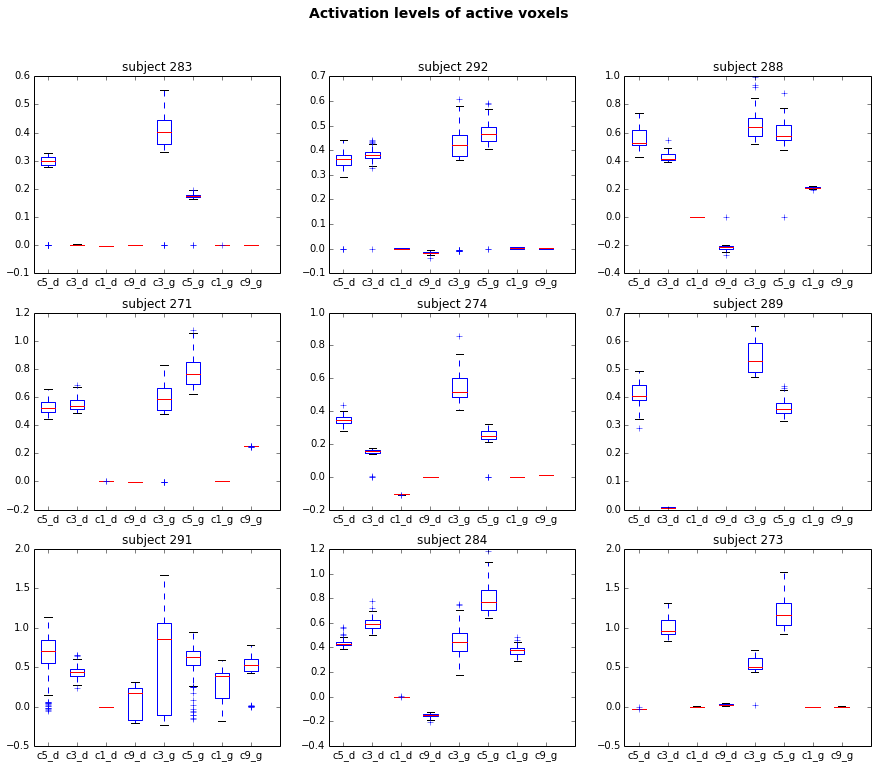

In [339]:
# Choose threshold for activated voxels p(q_j=1)
th = 0.5

f, ax = plt.subplots(3, 3, figsize=(15, 12)) #, sharex=True, sharey=True)
f.suptitle('Activation levels of active voxels', fontsize=14, fontweight='bold')
for isub, subject in enumerate(subjects[:]):
    brls_fn = op.join(archives, 'MAP-VS-' + subject, vem_dir, brls_n)
    labs_fn = op.join(archives, 'MAP-VS-' + subject, vem_dir, labels_n)
    brls_v = nib.load(brls_fn).get_data()
    labs_v = nib.load(labs_fn).get_data()
    (brls_0, brls_1, brls_2, brls_3,
     brls_4, brls_5, brls_6, brls_7) = (brls_v[:, :, :, 0], brls_v[:, :, :, 1], brls_v[:, :, :, 2], brls_v[:, :, :, 3],
                                        brls_v[:, :, :, 4], brls_v[:, :, :, 5], brls_v[:, :, :, 6], brls_v[:, :, :, 7])
    brls = [brls_0[labs_v[:, :, :, 0, 1]>th], brls_1[labs_v[:, :, :, 1, 1]>th], brls_2[labs_v[:, :, :, 2, 1]>th],
            brls_3[labs_v[:, :, :, 3, 1]>th], brls_4[labs_v[:, :, :, 4, 1]>th], brls_5[labs_v[:, :, :, 5, 1]>th],
            brls_6[labs_v[:, :, :, 6, 1]>th], brls_7[labs_v[:, :, :, 7, 1]>th]]
    ax[isub%3, isub/3].boxplot(brls)
    ax[isub%3, isub/3].set_title('subject ' + subject)
    plt.sca(ax[isub%3, isub/3])
    plt.xticks(range(1, 10), labels)
#plt.setp(ax, xticks=range(1, 10), xticklabels=labels)

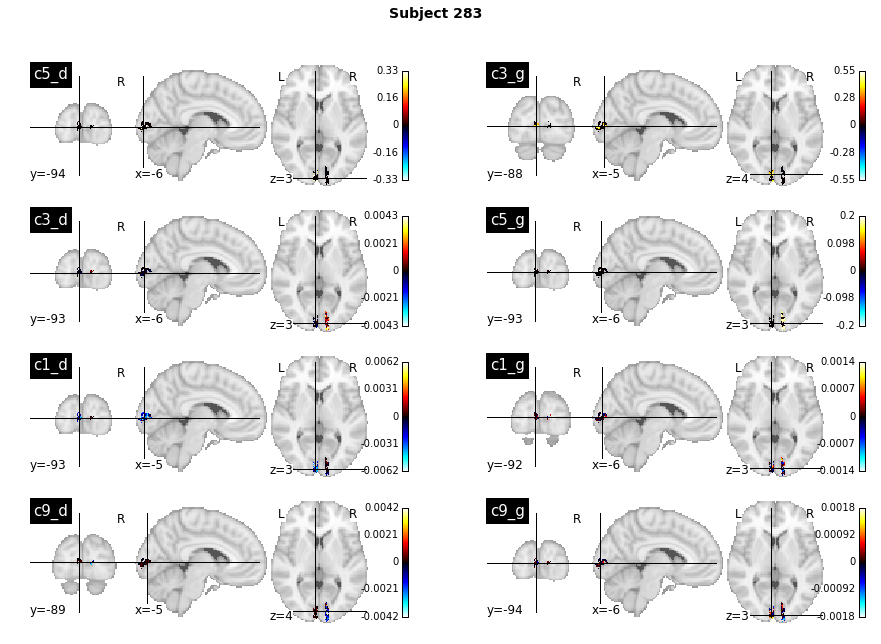

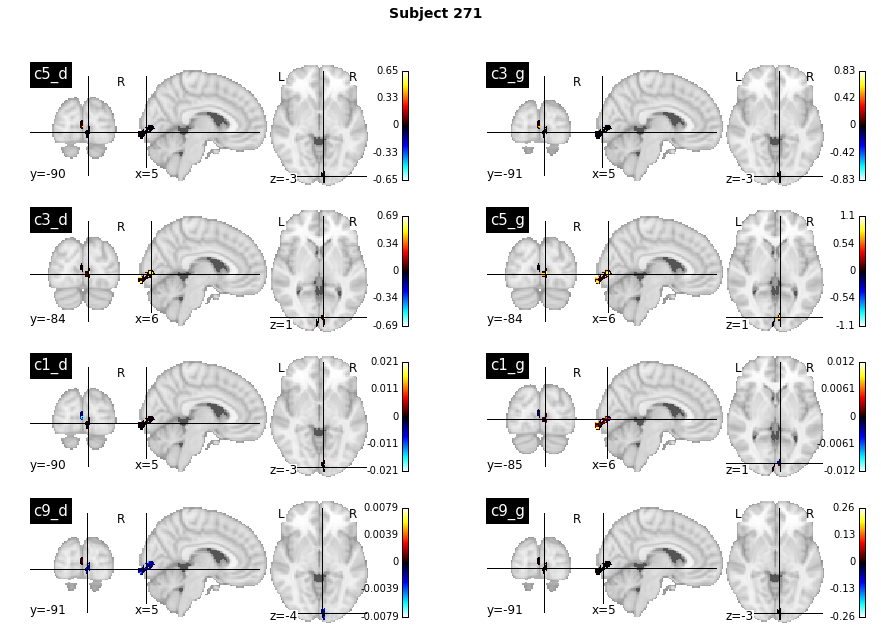

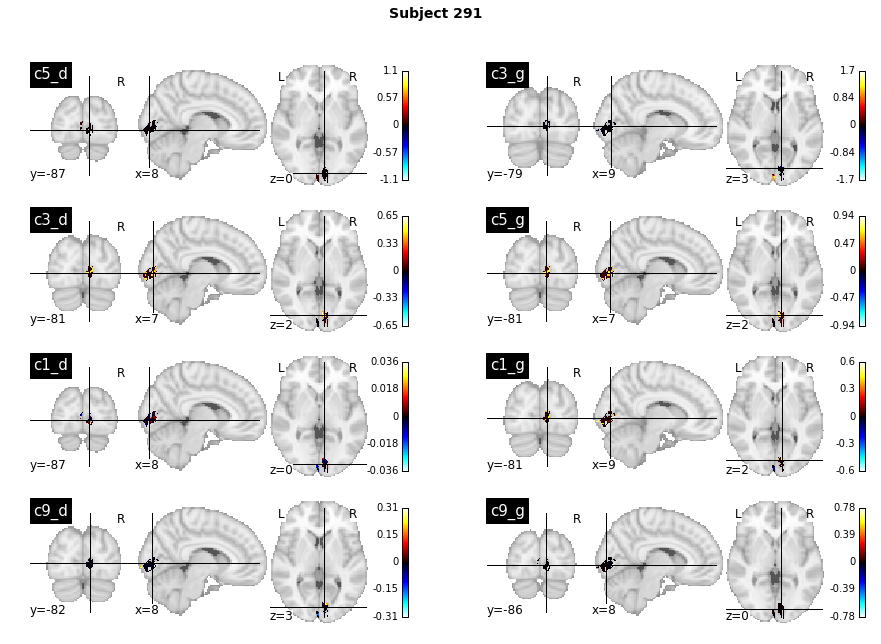

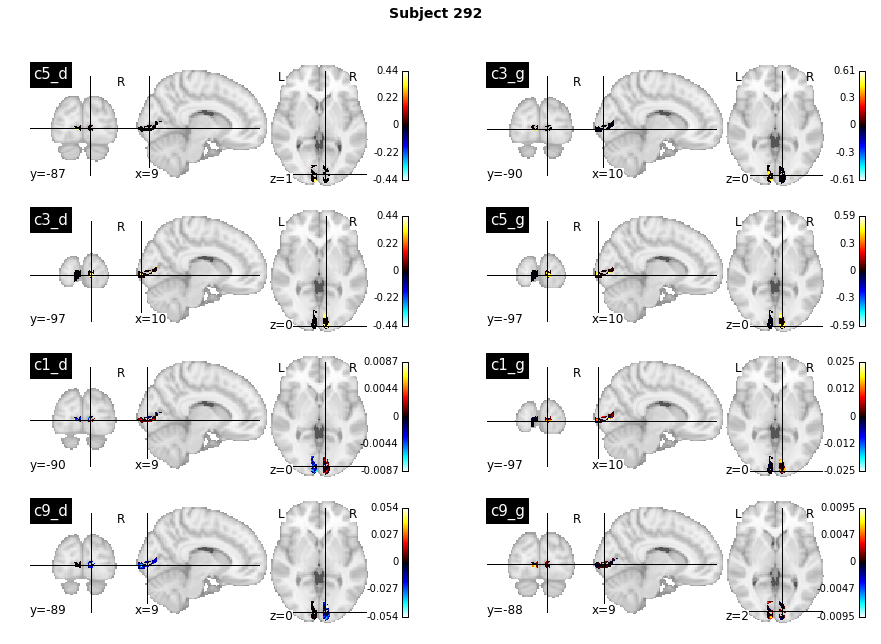

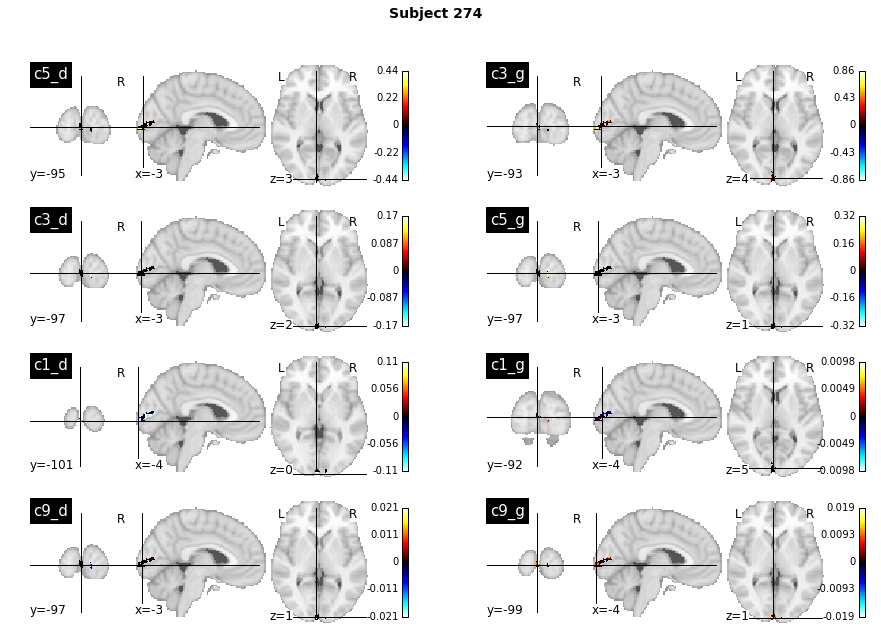

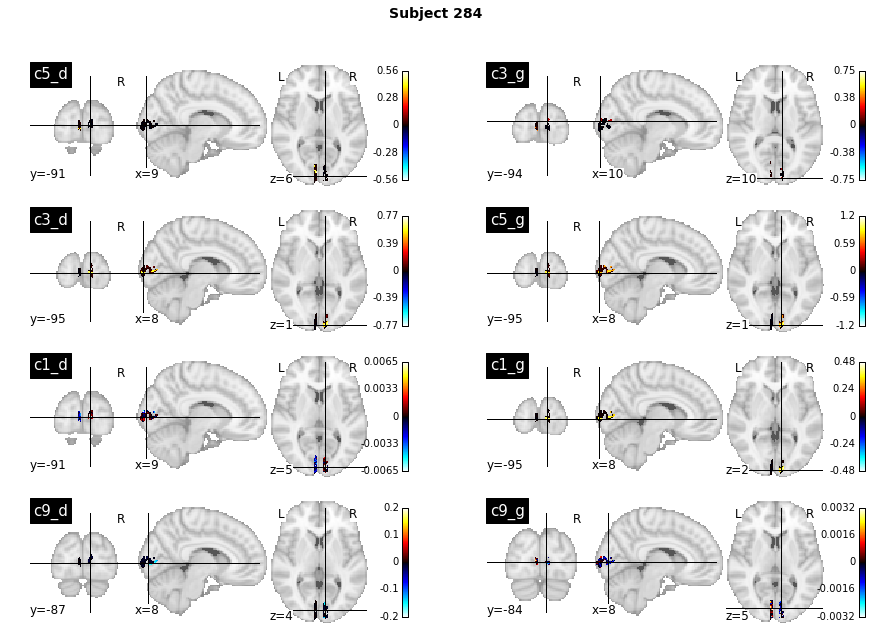

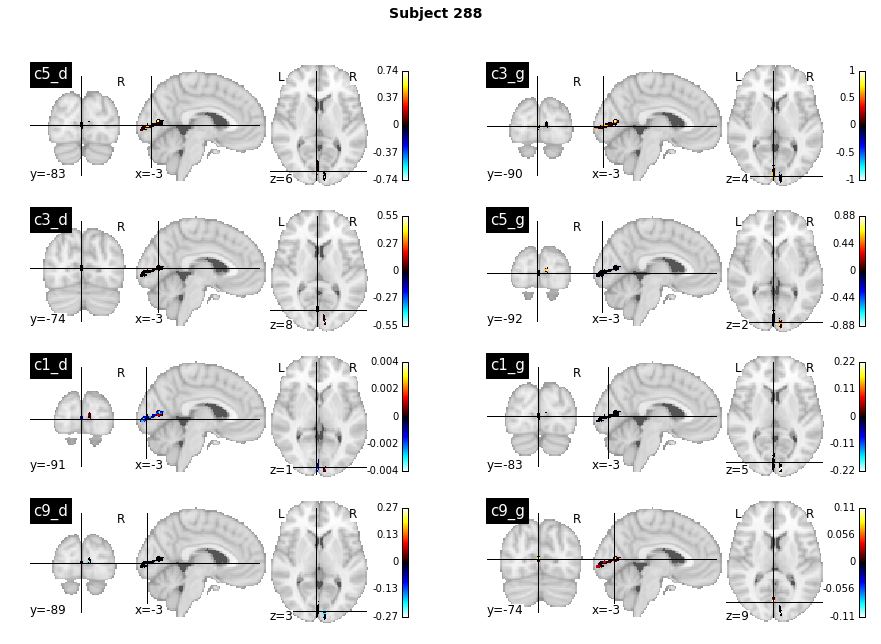

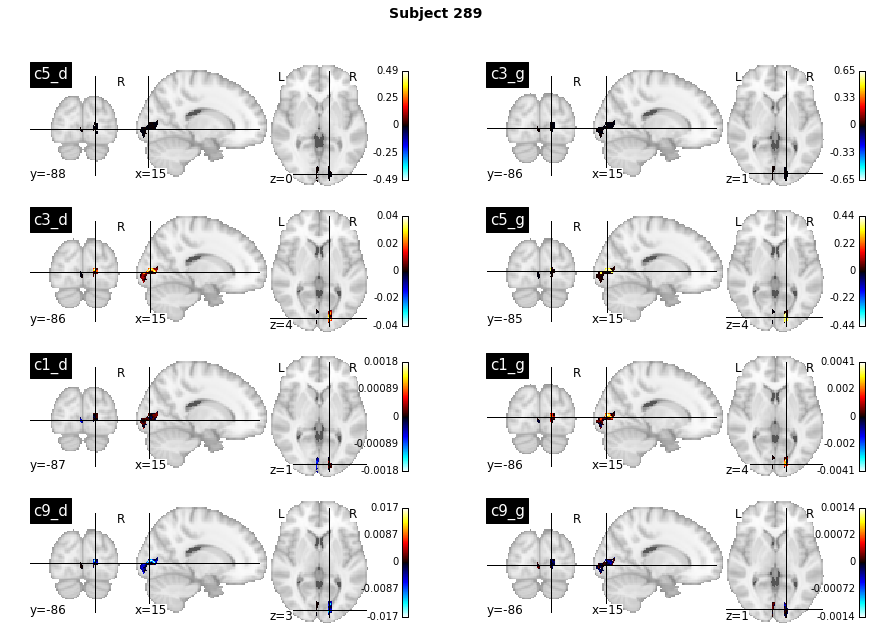

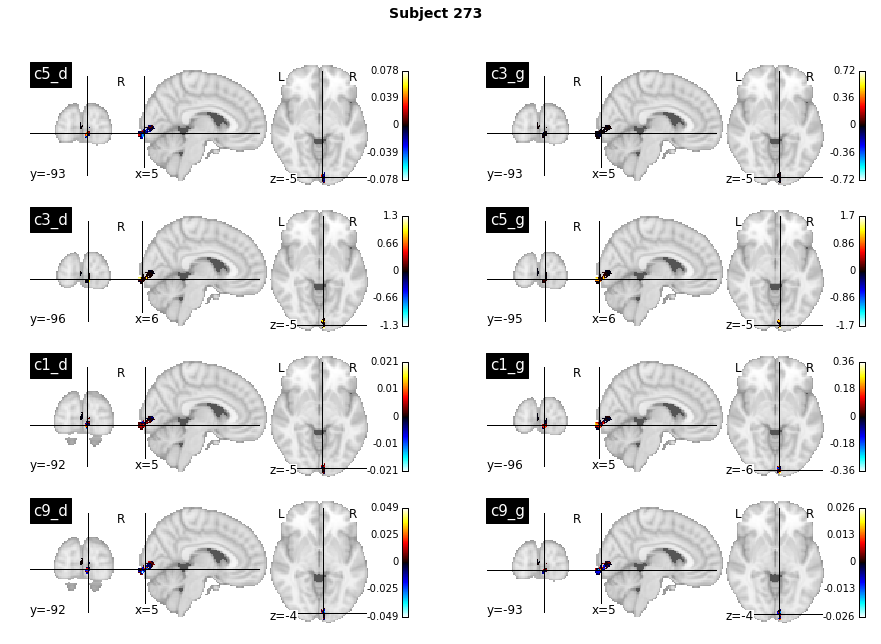

In [338]:
from nipy.labs.viz import plot_map, cm, mni_sform
from nilearn.plotting import plot_stat_map

for isub, subject in enumerate(subjects[:]):
    brls_fn = op.join(archives, 'MAP-VS-' + subject, vem_dir, brls_n)
    brls = nib.load(brls_fn)
    brls_v = brls.get_data()
    affine = brls.get_affine()

    f, ax = plt.subplots(4, 2, figsize=(15, 10))
    f.suptitle('Subject ' + subject, fontsize=14, fontweight='bold')
    n_cond = 8
    for icond in xrange(n_cond):
        img = nib.Nifti1Image(brls_v[:, :, :, icond], affine=affine)
        fn = 'tmp_file.nii.gz'
        nib.save(img, fn)
        plot_stat_map(img, title=labels[icond], figure=f, axes=ax[icond%(n_cond/2), icond/(n_cond/2)])


In [392]:
plot_stat_map?

<function __main__.show_image>

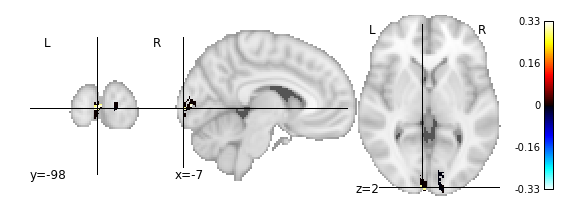

In [422]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML
%pylab inline

def show_image(x, y, z, path ):
    img = nib.load(path)
    plot_stat_map(img, cut_coords=(x, y, z))


subject = subjects[0]
icond = 0

brls = nib.load(op.join(archives, 'MAP-VS-' + subject, vem_dir, brls_n))
img = nib.Nifti1Image(brls.get_data()[:, :, :, icond], affine=affine)
fn = 'tmp_file.nii.gz'
nib.save(img, fn)

affine = brls.get_affine()
data_shape_mni = img.get_data().shape * np.abs(np.diag(affine[:3, :3]))
ind_max = np.unravel_index(img.get_data().argmax(), img.get_data().shape)
ind_max_mni = np.dot(ind_max, affine[:3, :3]) + affine[:3, 3]

interact( show_image, path = fn,
         x=widgets.IntSliderWidget(min=-data_shape_mni[0], max=data_shape_mni[0], step=1, value=ind_max_mni[0]),
         y=widgets.IntSliderWidget(min=-data_shape_mni[1], max=data_shape_mni[1], step=1, value=ind_max_mni[1]),
         z=widgets.IntSliderWidget(min=-data_shape_mni[2], max=data_shape_mni[2], step=1, value=ind_max_mni[2]))

In [439]:
from pyhrf.core import FmriData
bold_fn = op.join(archives, 'MAP-VS-' + subject, 'EPI1_501_EPI_ParkCS',
                  'wrrMAP-VS-' + subject + '_EPI_ParkCS_1_5_SENSE.nii')
bold = nib.load(bold_fn).get_data()
print bold.shape

def load_data(archives, subject, tr):
    # Folder and file names
    data_fn = op.join(archives, 'MAP-VS-' + subject, 'EPI1_501_EPI_ParkCS',
                  'wrrMAP-VS-' + subject + '_EPI_ParkCS_1_5_SENSE.nii')
    paradigm_fn = op.join(archives, 'paradigm_data', 'visual_block1b.csv')
    dilate = True
    roi_mask_fn = op.join(archives, 'MAP-VS-' + subject, 'roi_visual_dilated_ofs_lr.nii')
    # Load data
    fdata = FmriData.from_vol_files(roi_mask_fn, paradigm_fn, [data_fn], tr)
    return fdata

#roi_data = load_data(archives, subjects[0], tr)

MemoryError: 